In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import sys

def compute_receptive_field(act, x, y, bin_size):
    # batch size and the number of neurons
    num_neuron = act.shape[0];
    # sampling size for gaussian smoothing
    sample_size = int(np.minimum(bin_size[0], bin_size[1]) / 4);
    if sample_size % 2 == 0 :
        sample_size += 1;
    
    # receptive field
    receptive_fields = np.zeros((num_neuron, bin_size[1], bin_size[0]));
    # compute receptive field with spatial position
    map_x = x.reshape(-1);
    map_y = y.reshape(-1);
    for neuron_idx in np.arange(num_neuron):
        f = act[neuron_idx, :].reshape(-1);
        ratemap, _, _, _ = stats.binned_statistic_2d(map_y, map_x, f, 
                                                     statistic = lambda x : np.mean(x),
                                                     bins = [bin_size[1], bin_size[0]]);
        # Nan value complete
        ratemap_nan = np.copy(ratemap);
        nan_idx = np.where(np.isnan(ratemap_nan));
        
        # gaussian sampling 
        ratemap_nan[nan_idx] = 0.0;
        ratemap_nan = cv2.GaussianBlur(ratemap_nan, (sample_size, sample_size), 0);
        ratemap[nan_idx] = ratemap_nan[nan_idx];
        receptive_fields[neuron_idx] = ratemap;
    return receptive_fields;

def plot_receptive_field(activity, traj, plot_size=[1,1], bin_length=50, fig_size=[10,10]):
    ratemaps = compute_receptive_field(activity, traj[:, 0], traj[:, 1], [int(traj[:, 0].size/bin_length), int(traj[:, 1].size/bin_length)]);
    num_neuron = ratemaps.shape[0];
    plt.figure(figsize=fig_size);
    #plt.axis('off');
    for neuron_idx in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0], plot_size[1], neuron_idx + 1);
        plt.imshow(np.flipud(ratemaps[neuron_idx]), interpolation = 'gaussian');
    plt.show();

def simulate_plot(funcs, env_range, n, plot=True, bin_length=50, fig_size=[15,15]):
    traj_x = np.random.rand(n) * (env_range[0][1]-env_range[0][0]) + np.ones((n)) * env_range[0][0]
    traj_y = np.random.rand(n) * (env_range[1][1]-env_range[1][0]) + np.ones((n)) * env_range[1][0]
    traj = np.array([traj_x, traj_y]).T
    
    activity = np.array([[func(pos) for pos in traj] for func in funcs])
    if plot:
        plot_receptive_field(activity, traj, plot_size=[int(len(funcs)**0.5), int(len(funcs)**0.5)], bin_length=bin_length, fig_size=fig_size)
    return traj, activity

plt.figure(figsize=[15,15]);
#plt.subplot(1, 1, 1);
def plot_traj(traj, env_range=[(-200, 200), (-200, 200)], iExp=0):
    if iExp == -1:
        return
    #print((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #print((np.max(traj[:, 1]), np.min(traj[:, 1])));
    colors = ['k', 'c', 'y', 'g', 'b']
    plt.plot(traj[:, 0], traj[:, 1], colors[iExp]+'.-');
    plt.xlim(env_range[0]);
    plt.ylim(env_range[1]);
    #plt.xlim((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #plt.ylim((np.min(traj[:, 1]), np.max(traj[:, 1])));
    #plt.axis('scaled');
    #plt.axis('off');
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    #plt.title('Trajectory');
    #plt.show();

<Figure size 1080x1080 with 0 Axes>

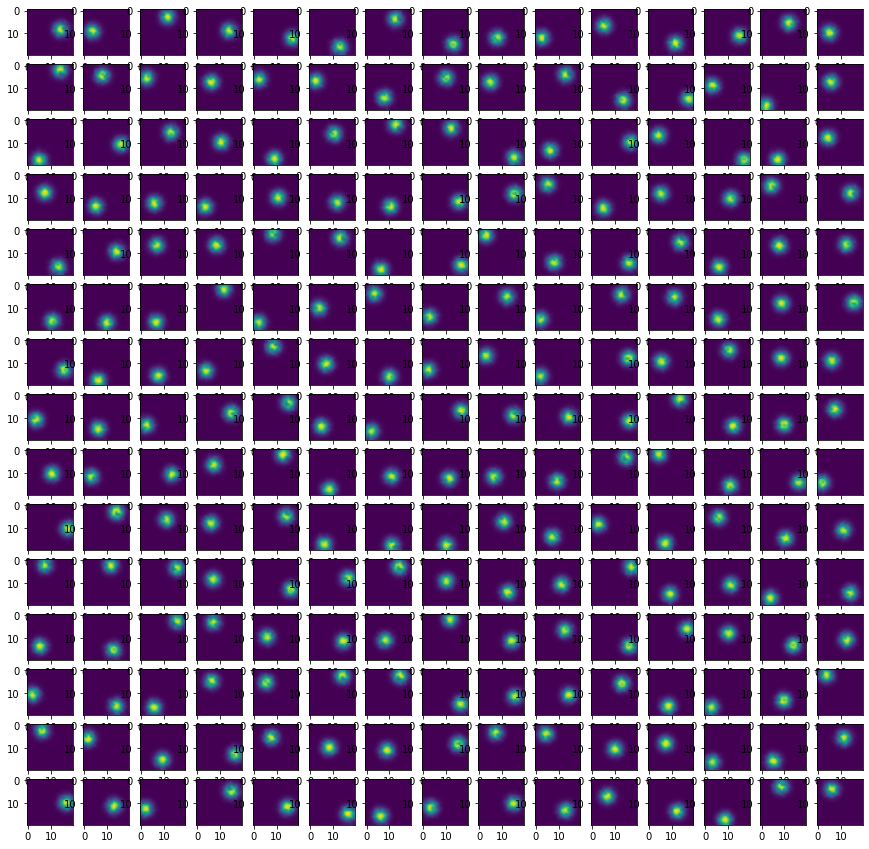

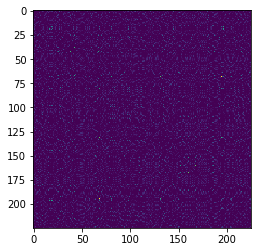

In [2]:
def makeGaussian(r0, sigma):
    def gaussian(pos):
        return np.exp(-((float(pos[0]-r0[0]))**2+(float(pos[1]-r0[1]))**2)/sigma**2)
        #val = np.exp(-((float(pos[0]-r0[0]))**2+(float(pos[1]-r0[1]))**2)/sigma**2)
        #if val > 0.3:
        #    return val
        #else:
        #    return 0.0
    return gaussian

def randPos(env_range):
    return [random.random() * (env_range[0][1]-env_range[0][0]) + env_range[0][0], random.random() * (env_range[1][1]-env_range[1][0]) + env_range[1][0]]

class MPCpopulation:
    def __init__(self, map_size, env_range, r0_range, sigma=100):
        nPC = map_size[0]*map_size[1]
        self.rw = np.zeros([nPC, nPC]) # recurrent weights
        self.cnt = 0
        
        useRand = True
        if useRand:
            r0x = np.random.rand(nPC) * (r0_range[0][1]-r0_range[0][0]) + np.ones((nPC)) * r0_range[0][0]
            r0y = np.random.rand(nPC) * (r0_range[1][1]-r0_range[1][0]) + np.ones((nPC)) * r0_range[1][0]
            r0s = np.array([r0x, r0y]).T
        else:
            r0s = []
            for i in range(map_size[0]):
                for j in range(map_size[1]):
                    r0s.append([r0_range[0][0]+i*(r0_range[0][1]-r0_range[0][0])/map_size[0], r0_range[1][0]+j*(r0_range[1][1]-r0_range[1][0])/map_size[1]])
        self.MPCs = [makeGaussian(r0, sigma) for r0 in r0s]
                
    def trainHopfield(self, y):
        nNodes = len(self.MPCs)
        rw = np.matmul(y.reshape((1, -1)).T, y.reshape((1, -1)))
        mask = np.ones((nNodes, nNodes)) - np.identity(nNodes)
        rw = rw*mask
        self.rw = ( self.rw*self.cnt + rw/np.linalg.norm(rw.reshape(-1), axis=0) )/(self.cnt+1)
        self.cnt += 1
        
    def showRW(self):
        plt.figure();
        plt.imshow(self.rw);
        plt.show();
    
    def triggeredResponse(self, act):
        #print(np.max(act), np.max(self.rw), np.max(np.matmul(act.reshape((1, -1)), self.rw)))
        return np.matmul(act.reshape((1, -1)), self.rw)
    
    

env_range = [[-190, 190], [-190, 190]]
r0_range = [[-150, 150], [-150, 150]]

MPCpop = MPCpopulation([15,15], env_range, r0_range, sigma=50)

''' exploration (building recurrent network) '''
traj, activity = simulate_plot(MPCpop.MPCs, env_range, 1000)
for y in activity.T:
    MPCpop.trainHopfield(np.array(y))
MPCpop.showRW()


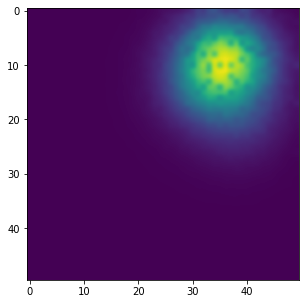

In [3]:
class GoalCell:
    def __init__(self, nPC):
        self.nPC = nPC # number of place cells
        self.w = np.zeros(nPC)
        self.gc_max = 0
        self.data = []
    
    def response(self, PCact, record=False):
        res = np.dot(self.w, PCact)
        if record:
            self.data.append(res)
        return res
    
    def responseFunc(self, MPCpop):
        def res(pos):
            return np.dot(self.w, np.array([mpc(pos) for mpc in MPCpop.MPCs]))
        return res
    
    def memorizeReward(self, PCact, PCpop, tRange = 50, decay = 0.8):
        #self.w = np.zeros(self.nPC) # reset
        # synapses from currently firing place cells are enhanced
        self.w += PCact/np.linalg.norm(PCact, axis=0)
        ripple = PCact/np.linalg.norm(PCact, axis=0)
        for t in range(tRange):
            ripple = PCpop.triggeredResponse(ripple).reshape(-1)
            ripple /= np.linalg.norm(ripple, axis=0)
            self.w +=  ripple * (decay**(t+1))
        self.w /= np.linalg.norm(self.w, axis=0)
        self.gc_max = self.response(PCact)
    
    def forget(self, factor=1000):
        self.w /= factor
        self.gc_max /= factor


pos = [100, 100] # reward position
pos2 = [-100, -100] # new reward position
plot_range = env_range 
#plot_range = [[50, 150], [50, 150]]

''' memorization (building V value expression) '''

gc = GoalCell(len(MPCpop.MPCs))
gc.memorizeReward(np.array([mpc(pos) for mpc in MPCpop.MPCs]), MPCpop, tRange=3, decay=0.1)
traj, activity = simulate_plot([gc.responseFunc(MPCpop)], plot_range, 5000, bin_length=100, fig_size=[5,5])
#print(gc.gc_max)

#gc.forget()
#traj, activity = simulate_plot([gc.responseFunc(MPCpop)], env_range, 5000, bin_length=40, fig_size=[5,5])
#
#gc.memorizeReward(np.array([mpc(pos2) for mpc in MPCpop.MPCs]), MPCpop, tRange=50, decay=0.8)
#traj, activity = simulate_plot([gc.responseFunc(MPCpop)], plot_range, 5000, bin_length=40, fig_size=[5,5])
#print(gc.gc_max)


In [4]:
def move(action, pos, speed=5): # [MOVE_LEFT, MOVE_RIGHT, MOVE_FORWARD, MOVE_BACKWARD] # [+y, -y, +x, -x] # facing +x
    if action[0]:
        return [pos[0], pos[1]+speed]
    elif action[1]:
        return [pos[0], pos[1]-speed]
    elif action[2]:
        return [pos[0]+speed, pos[1]]
    elif action[3]:
        return [pos[0]-speed, pos[1]]
    else:
        print("ERROR! not moving")
        return pos

def randMove(pos, avoidWall=False, speed=5):
    actions = np.identity(4, dtype = int)
    mask = np.ones(4, dtype=bool)

    if avoidWall:
        if pos[0] > 180:
            mask[2] = False # inhibit MOVE_FORWARD
        if pos[0] < -180:
            mask[3] = False # inhibit MOVE_BACKWARD
        if pos[1] > 180:
            mask[0] = False # inhibit MOVE_LEFT
        if pos[1] < -180:
            mask[1] = False # inhibit MOVE_RIGHT
    actions = actions[mask].tolist()
    action = random.choice(actions)
    return move(action, pos, speed), action

def go_back_turn(ori_dir, pos, speed=5):
    actions = np.identity(4, dtype = int)
    opposite = ori_dir
    
    if ori_dir[0]:
        opposite[0] = 0
        opposite[1] = 1
        actions = np.delete(actions, 0, axis=0)
    elif ori_dir[1]:
        opposite[0] = 1
        opposite[1] = 0
        actions = np.delete(actions, 1, axis=0)
    elif ori_dir[2]:
        opposite[2] = 0
        opposite[3] = 1
        actions = np.delete(actions, 2, axis=0)
    elif ori_dir[3]:
        opposite[2] = 1
        opposite[3] = 0
        actions = np.delete(actions, 3, axis=0)
    
    return move(opposite, pos, speed), random.choice(actions.tolist())


    
def exploitation(MPCpop, gc, rewardPos, tolerance, initPos, nMoves=100, iExp=0):
    rewarded = False
    gc.data = []
    # random initial position
    pos = initPos
    traj = [pos]
    mpc_activity = [mpc(pos) for mpc in MPCpop.MPCs]
    gc_activity = gc.response(mpc_activity, True)
    
    speed = 4
    p = 0.01
    threshold_low = gc.gc_max*0.7
    threshold_high = gc.gc_max*0.95
    #print(threshold_low, threshold_high)
    pos, direction = randMove(pos, True) # randomly decide a direction
    traj.append(pos)
    
    for i in range(nMoves):
        mpc_activity = [mpc(pos) for mpc in MPCpop.MPCs]
        #MPCpop.trainHopfield(np.array(mpc_activity))
        gc_activity = gc.response(mpc_activity, True)
        ori_pos = pos
    
        if gc_activity < threshold_high or len(gc.data) < 3:
            if gc_activity < threshold_low:
                #sys.stdout.write("fast ")
                speed = 20#15
            else:
                #sys.stdout.write("medium ")
                speed = 15#8
            
            if gc.data[-2] < gc_activity: # current position is better than the last; i.e. direction is good
                #sys.stdout.write("following gradient ")
                pos = move(direction, pos, speed)
            else:
                #sys.stdout.write("going back and turn ")
                pos, direction = go_back_turn(direction, pos, speed)
                pos = move(direction, pos, speed)
        
        else:
            #sys.stdout.write("slow ")
            speed = 4
        
            if gc.data[-2] < gc_activity or gc.data[-3] < gc_activity: # current position is better than the last; i.e. direction is good
                #sys.stdout.write("following gradient ")
                pos = move(direction, pos, speed)
            else:
                #sys.stdout.write("going back and turn ")
                pos, direction = go_back_turn(direction, pos, speed)
                pos = move(direction, pos, speed)
        
        traj.append(pos)
        #print(ori_pos, gc_activity)
        
        
        if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
            print("reward!", i)
            rewarded = True
            break
    if not rewarded:
        print("fail!")
        while not rewarded:
            pos, direction = randMove(pos, avoidWall=True, speed=random.randint(10,30))
            traj.append(pos)
            if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
                break
    plot_traj(np.array(traj), iExp=iExp)
    return rewarded


In [5]:
''' forgetting & re-searching '''

# simple multi-stage strategy
def ratGo(MPCpop, gc, rewardPos, tolerance, initPos, iExp=0):
    if not exploitation(MPCpop, gc, rewardPos, tolerance, initPos, nMoves=150, iExp=iExp):
        # if failed to find the reward in nMoves, the rat believes the reward position has changed
        print("forget...")
        gc.forget()
        # skip the random search process and assume at some point it will get to the new position
        gc.memorizeReward(np.array([mpc(rewardPos) for mpc in MPCpop.MPCs]), MPCpop, tRange=3, decay=0.1)
        #print(gc.gc_max)
        #traj, activity = simulate_plot([gc.responseFunc(MPCpop)], plot_range, 5000, bin_length=40, fig_size=[5,5])

def unifiedStrategy(MPCpop, gc, rewardPos, tolerance, initPos, iExp=0):
    rewarded = False
    gc.data = []
    # initial position & responses
    pos = initPos
    traj = [pos]
    mpc_activity = [mpc(pos) for mpc in MPCpop.MPCs]
    gc_activity = gc.response(mpc_activity, True)
    
    speed = 4
    p = np.exp(-gc.gc_max) # possibility to random walk
    threshold_low = gc.gc_max*0.7
    threshold_high = gc.gc_max*0.95
    
    pos, direction = randMove(pos, True) # randomly decide an initial direction
    traj.append(pos)
    
    while not rewarded:
        mpc_activity = [mpc(pos) for mpc in MPCpop.MPCs]
        gc_activity = gc.response(mpc_activity, True)
        ori_pos = pos
        
        if random.random() < p:
            pos, direction = randMove(pos, avoidWall=True, speed=random.randint(10,30))
        else:
            if gc_activity <= threshold_high or len(gc.data) < 3:
                if gc_activity <= threshold_low:
                    #sys.stdout.write("fast ")
                    speed = 20#15
                else:
                    #sys.stdout.write("medium ")
                    speed = 15#8
                
                ##### far away -- random walk or follow gradient? #####
                
                if gc.data[-2] < gc_activity: # current position is better than the last; i.e. direction is good
                    #sys.stdout.write("following gradient ")
                    pos = move(direction, pos, speed)
                else:
                    #sys.stdout.write("going back and turn ")
                    pos, direction = go_back_turn(direction, pos, speed)
                    pos = move(direction, pos, speed)
            
            else:
                #sys.stdout.write("slow ")
                speed = 4
            
                if gc.data[-2] < gc_activity or gc.data[-3] < gc_activity: # current position is better than the last; i.e. direction is good
                    #sys.stdout.write("following gradient ")
                    pos = move(direction, pos, speed)
                else:
                    #sys.stdout.write("going back and turn ")
                    pos, direction = go_back_turn(direction, pos, speed)
                    pos = move(direction, pos, speed)
        
        traj.append(pos)
        #print(ori_pos, gc_activity, p)
        
        if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
            print("reward!", len(traj))
            rewarded = True
            gc.memorizeReward(np.array([mpc(rewardPos) for mpc in MPCpop.MPCs]), MPCpop, tRange=3, decay=0.1)
            break
        else:
            gc.forget(1.01) # gradually forget
            p = np.exp(-gc.gc_max)
            threshold_low = gc.gc_max*0.7
            threshold_high = gc.gc_max*0.95
        
        if len(traj) > 5000:
            print("fail!")
            break
    plot_traj(np.array(traj), iExp=iExp)

reward! 2074
new reward position: [-41.19480336631389, 98.03684190092633]
fail!
forget...
reward! 34
reward! 18
reward! 27
reward! 34


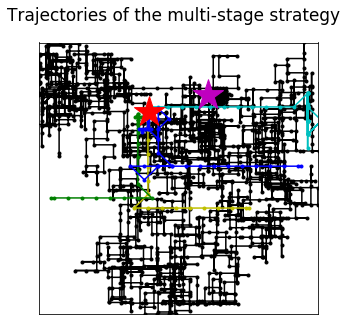

In [40]:
nExps = 1 # number of changing reward position
nTrails = 5 # number of testing of the same reward position

tolerance = 10
gc.w = np.zeros(gc.nPC)
gc.gc_max = 0
rewardPos = randPos([[-130, 130], [-130, 130]])
unifiedStrategy(MPCpop, gc, rewardPos, tolerance, randPos(env_range), iExp=-1)
plt.scatter(rewardPos[0], rewardPos[1], s=1000, c='m', marker='*', zorder=10)

for exp in range(nExps):
    rewardPos = randPos([[-130, 130], [-130, 130]])
    print("new reward position:", rewardPos)
    for trial in range(nTrails):
        #unifiedStrategy(MPCpop, gc, rewardPos, tolerance, randPos(env_range), iExp=trial)
        ratGo(MPCpop, gc, rewardPos, tolerance, randPos(env_range), iExp=trial)
    plt.scatter(rewardPos[0], rewardPos[1], s=1000, c='r', marker='*', zorder=10)
#plt.show();
plt.suptitle('Trajectories of the multi-stage strategy', fontsize=17);
plt.gcf().set_size_inches(5,5)
plt.savefig('../multi.png', dpi=200)

In [7]:
'''
Questions:
- Do we need to include more time-steps in Hopfield training?
- Do we need to propagate the signal in memorization?

Next Steps:
- Migrate back to grid-place system
- Migrate back to V1-place system
- Deal with orientation problem
'''

'\nQuestions:\n- Do we need to include more time-steps in Hopfield training?\n- Do we need to propagate the signal in memorization?\n\nNext Steps:\n- Migrate back to grid-place system\n- Migrate back to V1-place system\n- Deal with orientation problem\n'